# Solving our ice sheet model numercially

In tthe preceding pages we derived an ice sheet model using the Shallow Ice Approximation. On this page we will try to get some insight into how ice sheets operate by solving this simple ice-sheet model numerically. 

## The SIA ice sheet model
As with most mathematical models, we will define the model equations, the boundary conditions, the initial conditions and the forcing. 
## Model equations
Applying mass conservation led to a depth-integrated mass balance equation (Eqn {eq}`eq:depth_int_mass_balance`), which describes how the ice thickness changes as a function of the ice-equivelent accumulation rate $a$ and ice flux $q$:
$$
\frac{\partial H}{\partial t} = a - \frac{\partial q}{\partial x},
$$

where $x$ is the horizontal coordinate, $H$ is the ice thickness, $t$ is time, $q$ is the depth-intergrated flux per unit width (hereafter, flux),

Appling a stress balance and Glen's flow law (i.e. the power law rheology of ice) led to an expression for the ice flux as a function of ice thickness (Eqn {eq}`eq:SIA_flux`): 

$$
q = -\frac{2A}{n+2} \left(\rho g \alpha \right)^n  H^{n+2}  
$$

where $A$ is the flow parameter from the flow law, $n$ is the exponent from the flow law, $\rho$ is the density of ice, $g$ is acceleration due to gravity, and $\alpha$ is the surface slope $\left(= - \frac{\partial H}{\partial x}\right)$.



### Boundary conditions
We will also impose a no-flow boundary condition on the right hand side. Let's think about what this looks like in our model as we go along.

We will also assume a flat bed topography.

### Initial conditions

We will start with an ice sheet with no ice, i.e. $H=0$ everywhere.

### Forcing
As a starting point we will impose the surface mass balance (SMB) as a simple linear function of distance:

$$
a = 10^{-4}\left(\frac{X}{3}-x\right), 
$$

where $X$ is the length of the spatial domain. We will discuss this choice of forcing in more detila below. 

## Numerical methods 
We will use a a simple finite-difference scheme. We descritize the space adn time domains into grids, where variables are defined at spatial grid points and at time steps. Then we approximate the derivatives as differences, e.g.

$$
\frac{\partial H}{\partial t} = \frac{H^{j+1}-H^{j}}{\Delta t}
$$

where $j$ refers to which time step and $\Delta t$ is the time interval between time steps. 

Applying this approximation (or more precisly a 'centered-difference version of the approximation) to the spatial derivatives gives

$$
\frac{\partial q}{\partial x}\bigg\rvert^j = \frac{ q^j_{i+1} - q^j_{i-1}}{2 \Delta x}
$$ 

and

$$
\frac{\partial H}{\partial x}\bigg\rvert^j = \frac{ H^j_{i+1} - H^j_{i-1}}{2 \Delta x},
$$

where $i$ refers to the spatial gridpoint.



Substituting these into our model gives

$$
\frac{H^{j+1}-H^{j}}{\delta t} = a - \frac{q^j_{i+1} - q^j_{i-1}}{2 \Delta x},
$$


$$
q^j_i = -\frac{2A}{n+2} \left(\rho g  \right)^n  {H^j_i}^{n+2}  \left(\frac{H^j_{i+1} - H^j_{i-1}}{2\Delta x}\right)^n.
$$


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm


## Set up time and space grids
The first step is to set up our descritized time and space domains. We will use units of years for time and meters for distance. Setting up the grid involves choosing a time step, a total number of years the simulation should last, a grid spacing, and a domain length:

In [2]:
# time domain
dt = 0.004                        # time step, units [years]
T = 3000                          # total length of simulation, units [years]
t = np.linspace(0,T,round(T/dt))  # the time grid, units [years]
Lt = t.size                       # record the length of the time grid for use later

In [3]:
# space domain
dx = 200                          # grid spacing, units [m]
X = 40000                         # domain length, units [m]
x = np.linspace(0,X,round(X/dx))  # spatial grid, units [m]
Lx = x.size                       # record the length of the spatial grid for use later

The numerical scheme is a more stable if we evaluate the flux $q$ on a staggered grid. This is a grid of points that lie at the midpoints of all the normal grid points. This will allow us to easily evaluate the gradient of $q$ back on the normal grid to evolve $H$ forward in time. 

In [4]:
x_stag = x[0:-1] + 0.5*dx

Note that the staggered grid has one less element that the normal grid:


In [5]:
print(f'The staggered grid has {x_stag.size} elements,')
print(f'whereas the normal grid has {Lx} elements.')

The staggered grid has 199 elements,
whereas the normal grid has 200 elements.


Let's visualize the two grids to make sure we understand their arrangement.

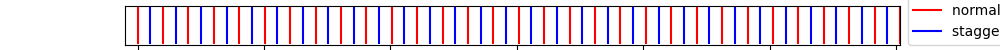

In [6]:
def grid_plotting_arrays(x):
    # Create two arrays with the same number of columns as the spatial grid. This is simply for plotting the grids.
    stacked_x = np.stack([x, x])      # the first one has each column made up of two instances of each grid point. 
    zero_one = np.stack([0*x, 0*x+1]) # the second one has each column made up of a zero and a one. 
    return stacked_x, zero_one

plt.figure(figsize=(10, 0.5))

h1 = plt.plot(grid_plotting_arrays(x)[0],
         grid_plotting_arrays(x)[1], 
         color = 'red', 
         label = 'normal grid')

h2 = plt.plot(grid_plotting_arrays(x_stag)[0],
         grid_plotting_arrays(x_stag)[1], 
         color = 'blue', 
         label = 'staggered grid')

plt.xlabel('distance, $x$ [m]', size = 25)
plt.xlim(x[0]-100, x[30])
plt.legend(handles=[h1[0], h2[0]], loc=(1.01,0))
plt.yticks([], []);
plt.xticks(size = 20);

The red lines in the plot above show the locations of the grid point in the normal, unstaggered grid and the blue lines show the staggered grid. They alternate and are evenly spaced.

## Define physical constants
These are the parameters that we will not be varying in our model.

We include a small numerical parameter `e`. In places where $H = 0$, the physics that our model describes do not apply, so a simple (but crude) way to avoid this is to never allow $H$ to go below this small value `e`.

In [7]:
n = 3.0                              # The flow law exponent
seconds_per_year = 365*24*60*60      # approximate number of seconds in year
A = 24*10**(-25) * seconds_per_year  # The flow law parameter, units [Pa a] (original value from Cuffey and Paterson 24e-25, units Pa s
rho = 917                            # ice density,  units [kg/m^3]
g = 10                               # acceleration due to gravity, units [m/s^2]
e = 0.0001                           # used to prevent ice thickness from reaching zero

## Preallocate the ice thickness array
For simplicity, we will save the ice thickness at every time step. To do this most efficiently, we 'pre-allocate' the memory for the array by creating an array the right width and height consisting of zeros. Notice that the time domain will correspond to the first index of `H` and the spatial domain will correspond to the second. 

In [8]:
H = np.zeros((Lt,Lx))

## Define initial conditions
Because our model contains a time derivative of ice thickness $H$, we need to assign $H$ an initial condition. This will be arbitrary, so we better make sure that the conclusions we draw from simulations do not rely on this arbitrary choice. 

For simicity we will make $H$ uniform initally and equal to `e`.

In [9]:
H[0,:] = e

## Prescribe the surface mass balance
The model is forced by the surface mass balance $a$. For simplicity, we will prescribe $a$ as a simple linear function of distance. 

$$
a = 10^{-4} \left( \frac{X}{3} - x \right)
$$

In [10]:
a = 10**-4 * (X/3-x)

Let's plot the surface mass balance as a function of $x$:

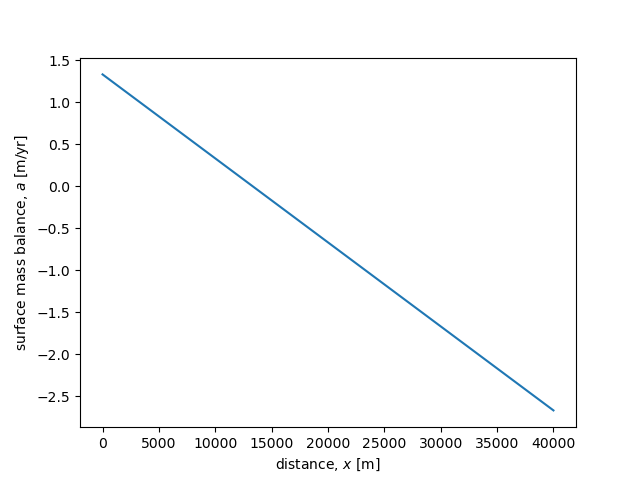

In [11]:
plt.figure()
plt.plot(x,a);
plt.xlabel('distance, $x$ [m]')
plt.ylabel('surface mass balance, $a$ [m/yr]')
plt.show()

This function says that $a$ is positive on the left of our model domain and decreases linearly with $x$, passing zero at $x=15000$ m. This is probably not how SMB really works; $a$ is more likely to be a function of elevation $\left(a(H)\right)$ rather than distance $\left(a(x)\right)$, but with a flat bed like this, $a(H)$ leads to unstable ice sheet growth or decay, so the only steady state we can reach is $H(x) = 0$, which isn't very interesting. So we will stick with this unrealistic way of imposing $a for now and we can always come back to this later and look at what happens when it is prescribed in a more realistic way. 


## Run the simulation
Finally, we are ready to run our simulation. 

We will loop through every time step. In each iteration, $j$ we will use the ice thickness from the previous time, $H^{j-1}$ step to compute the following:

1. the ice thickness on the staggered grid,
2. the surface slope, $\alpha$, on the staggered grid, using (1) 
3. the flux on the staggered grid, using (1) and (2), and 
4. the ice thickness at the current time step on the normal grid, using (3) and $\dot{b_i}$ 

The code in cell below is numbered to show where each step is happening. 

The code in the cell below also times the executiono the model with `%%time` and applies the boundary conditions. 

In [12]:
%%time

for timestep in tqdm(range(1, Lt)):
    # save the old thickness vector
    H_old  = H[timestep-1,:]
    
    # (1) compute H on the staggered grid
    H_stag = (H_old[1:] + H_old[:-1])/2
    
    # (2) compute the surface slope on the staggered grid.
    alpha = -(H_old[1:] - H_old[:-1])/dx 
    
    # (3) compute the flux on the staggered grid
    q = 2*A/(n+2) * (rho * g * alpha)**n * H_stag**(n+2)  
    
    # (4) compute the ice thickness at the current time step
    H[timestep,1:-1] = np.maximum(e, H_old[1:-1] + dt * ( a[1:-1] - (q[1:]-q[:-1])/dx ))    

    # apply the boundary conditions at x = 0 and x = X
    H[timestep,0] = H[timestep,1]
    H[timestep,-1] = e

100%|████████████████████████████████| 749999/749999 [00:10<00:00, 73261.28it/s]

CPU times: user 9.99 s, sys: 450 ms, total: 10.4 s
Wall time: 10.2 s


## Plot the results
The simplest result to plot is the final ice thickness, $H(x,T)$:

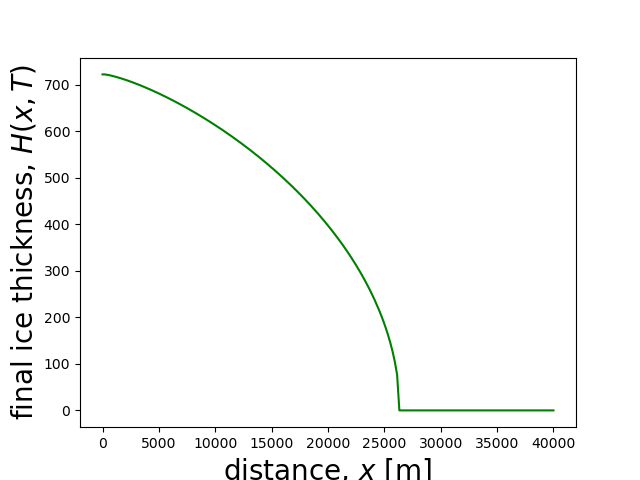

In [26]:
plt.figure()
plt.plot(x,H[-1,:], 
         color = 'green', 
         label = 'final ice thickness, $H(x,T)$');
plt.xlabel('distance, $x$ [m]', size = 20)
plt.ylabel('final ice thickness, $H(x,T)$', size = 20)
plt.show()


We can also plot the thickness profile $H(x)$ from every 10,000th timestep. We see that the glacier grows from the initial conditions of $H(t=0,x) = e$ and advances until we get a characteristic convex ice-sheet shape. This is caused by the interplay of thinning towards the terminus, the dependence of flux on thickness, and the spatial variability of flux. 

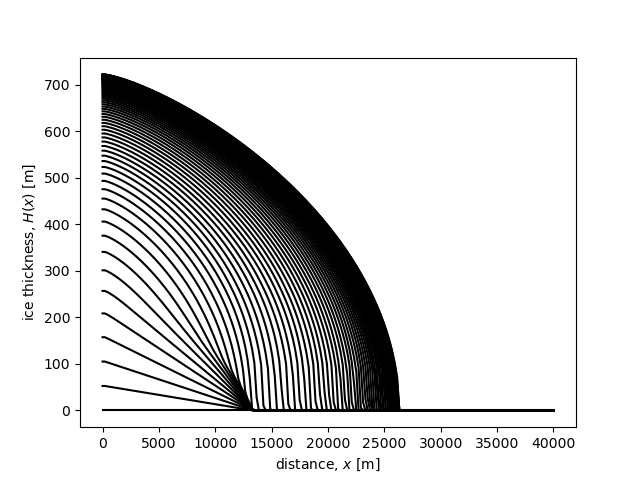

In [25]:
plt.figure()
plt.plot(x,np.transpose(H[0:-1:10000,:]), color = 'black');
plt.xlabel('distance, $x$ [m]')
plt.ylabel('ice thickness, $H(x)$ [m]')
plt.show()

Another kind of plot we can make is a time series of ice thickness from a particular location. In this case we will plot the ice thickness on the left side of the domain - the ice divide. 

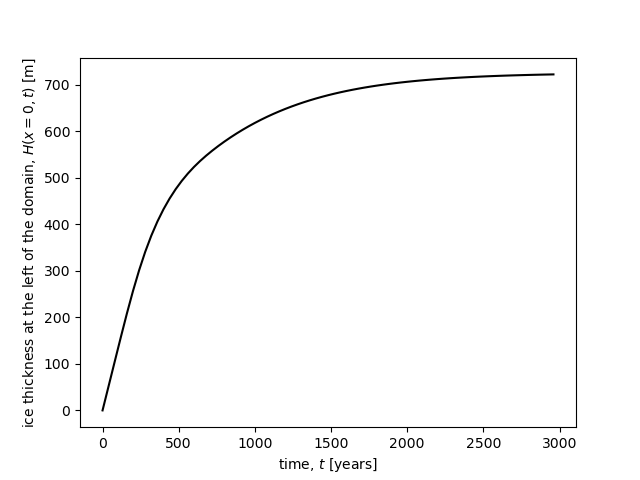

In [24]:
plt.figure()
plt.plot(t[0:-1:10000],np.transpose(H[0:-1:10000,0]), color = 'black');
plt.xlabel('time, $t$ [years]')
plt.ylabel('ice thickness at the left of the domain, $H(x=0,t)$ [m]')
plt.show()

We can also plot the final ice flux as follows.

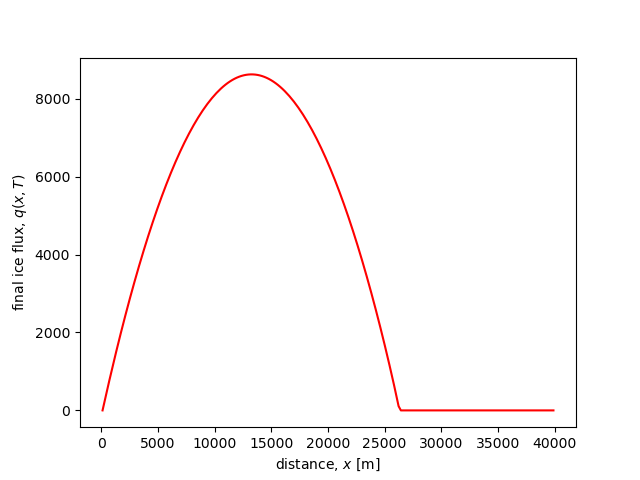

In [16]:
plt.figure()
plt.plot(x_stag,q, color = 'red');
plt.xlabel('distance, $x$ [m]', size = 10)
plt.ylabel('final ice flux, $q(x,T)$', size = 10)
plt.show()